# Neural Nets from scratch, in Numpy

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from autograd import grad, elementwise_grad, jacobian, numpy as autograd_np

## Network Architecture

LeCun et. al.'s seminal LeNet-5 is a great basic network to grok the implementation of the math behind neural nets. To begin with, we define a set of activation functions that add non-linearity to what is otherwise essentially a complex linear regression solver:

### Activations

In [2]:
def _relu(x):
    return autograd_np.maximum(0, x)

def _sigmoid(x):
    x_clip = autograd_np.clip(x, -700, 700)
    return 1 / (1 + autograd_np.exp(-x_clip))

activation_function_map = {
    'relu': _relu,
    'sigmoid': _sigmoid
}

Next, we define loss functions to measure the quality of the output layer. Since this is a classification problem, we need class membership probabilities; the sigmoid function is used as the activation of the final layer for this. The loss function, therefore, must compare this class membership probability vector against the label (ground truth) for that training observation. 

### Loss Functions

In [3]:
def _rmse(y, y_pred):
    # RMSE = sqrt of (1/n) summation{ (y_i - y_pred_i)**2 }
    return autograd_np.sqrt((1/y.shape[0]) * np.sum((y - y_pred) ** 2))

def _crossentropy(y, y_pred):
    # Prevent log(0)
    eps = 1e-15
    y_pred = autograd_np.clip(y_pred, eps, 1 - eps)

    # CE = -summation{ (y_i * log(y_pred_i) + (1-y_i)*log(1-y_pred_i)}
    return (1/y.shape[0]) * -autograd_np.sum((y * autograd_np.log(y_pred)) + ((1-y) * autograd_np.log(1-y_pred)))


## The Dense Layers 

The LeNet-5 architecture implements three dense (fully-connected) layers after feature extraction. This class defines a layer and supports weight and bias management - both during initialization as well as during backpropagation

In [11]:
class FullyConnectedLayer():
    def __init__(self, layer_config):
        self.input_size = layer_config['input_dim']
        self.output_size = layer_config['output_dim']

        # For random normal, mu=0, sigma=1
        mu, sigma = 0, 1
        self.W = np.random.normal(loc=mu, scale=sigma, size=(self.output_size, self.input_size))
        self.b =  np.random.normal(loc=mu, scale=sigma, size=self.output_size)
        activation_function = 'relu' if not layer_config.get('activation') else layer_config.get('activation')
        self.activation = activation_function_map[activation_function]
        
        # Current Layer: pre-activation and output values
        self.z = None
        self.a = None

        # Previous Layer: pre-activation output values for backprop
        self.prev_layer_z = None
        self.prev_layer_a = None


    def forward(self, input):
        # Ensure we do not anger the numpy gods
        assert input.shape[0] == self.W.shape[1], f"Shape mismatch: input dim {input.shape[0]} but W expects {self.W.shape[1]}"

        # Computation 1: z[l] = W[l] a · [l-1] + b[l] 
        self.z = np.dot(self.W, input) + self.b
        # Computation 2: a[l] = activation(z[l])
        self.a = self.activation(self.z)

        try:
            # Keeping track of prev layer output for backprop
            self.prev_layer_z = input.z
            self.prev_layer_a = input.a
        except AttributeError as e:
            # In case the prev layer is the raw input and not another FC Layer
            #print(f"Gracefully handling: {e}")
            self.prev_layer_z = None
            self.prev_layer_a = input

    def backward(self, dA):
        """
        Implement backpropagation.
        
        Args:
            dA: Gradient of loss L wrt. the output (activation) of this layer. Shorthand for to dL/da
        Returns:
            dA[l-1]: Gradient of loss L wrt. the output of the previous layer, for backprop.
        """

        # Step 1: Compute error signal (dL/dz[l]) called del[l] = dL/da[l] x σ'(z[l]), where σ' = activation derivative
        # del[l] = dL/da[l] x σ'(z[l]) 
        activation_derivative = elementwise_grad(self.activation)
        del_l = dA * activation_derivative(self.z)

        # Step 2: Compute loss grad wrt. W and b of current layer i.e. dL/dW[l] and dL/db[l]
        # dL/dw i.e. dW = del[l] x a[l-1].T
        # dL/db i.e. db = del[l]
        dW = np.outer(del_l, self.prev_layer_a)
        db = del_l

        # Step 3: Propagate dL/da[l-1] backwards to use in the del[l] calculation (Step 1) in the previous layer
        # del[l-1]  = W[l].T * del[l] * σ'(z[l-1])
        if self.prev_layer_z is not None:
            del_l_prev = np.dot(self.W.T, del_l) * activation_derivative(self.prev_layer_z)
        else:
            del_l_prev = np.dot(self.W.T, del_l)

        return del_l_prev

## Gathering Data: MNIST

LeNet-5 was trained on actual handwritten digits extracted from material belonging to the US Postal Service; fortunately, as the dataset is foundation ald quite popular, it is available to download and parse easily:

In [12]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

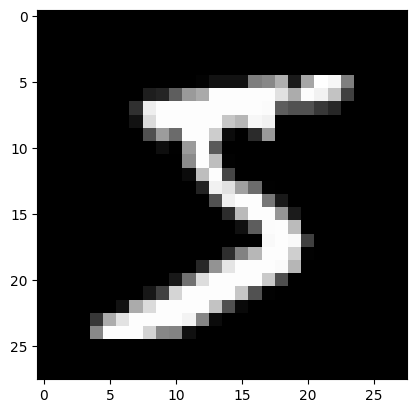

In [13]:
plt.imshow(X.values[0].reshape(28,28), cmap='gray')

## Implementing LeNet-5 (under construction)

### 1. The first forward pass

In [14]:
# LeNet-5 (only dense layers for testing)
input_layer =  FullyConnectedLayer(layer_config={'input_dim': 784,'output_dim': 30, 'activation': 'relu'})
hidden_layer = FullyConnectedLayer(layer_config={'input_dim': 30, 'output_dim': 10, 'activation': 'relu'})
output_layer = FullyConnectedLayer(layer_config={'input_dim': 10, 'output_dim': 10, 'activation': 'sigmoid'})

# Pick a sample from the training data and dump it directly into the first dense layer (input_layer).
# NOTE: for learning purposes only - eventually, there will be additional layers behind the dense layers 
# and so the output of those layers will be funneled into the first dense layer instead.
sample_num = 42
x = X.values[sample_num].copy()

# Forward pass through all layers
input_layer.forward(input=x)
hidden_layer.forward(input_layer.a)
output_layer.forward(hidden_layer.a)

# Compare prediction vs ground truth
y_true = np.eye(10)[int(y.values[sample_num])] 
y_pred = output_layer.a
loss = _crossentropy(y_true, y_pred)

print(f"Actual class label for sample {sample_num}: \n{y_true}")
print(f"Predicted class label probabilities for sample {sample_num} (rounded): \n{np.round(y_pred, decimals=3)}")
print(f"\nCrossEntropy Loss for first forward pass: {loss}")

Actual class label for sample 42: 
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Predicted class label probabilities for sample 42 (rounded): 
[1.    1.    1.    1.    1.    1.    0.    1.    0.311 1.   ]

CrossEntropy Loss for first forward pass: 24.214924232533306


### Okay, now what?
We now have a loss value that compares the actual class label (which will only have a single 1 in the one-hot-encoded vector of size $n$, where $n$ is the number of classes). The next step is, naturally, to adjust weights and biases - but how? For this, we need to understand how the Loss $L$ changes given a change in the weights $W$ or biases $b$. How do we do this? Calculus!

We now need to evaluate these two terms: $\frac{dL}{dW}$ and $\frac{dL}{db}$

1. $\frac{dL}{dW}$

    $\frac{dL}{dW} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dW} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times \frac{dz^{[2]}}{dW}$ 

    $Since \ \frac{dz^{[2]}}{dW} =  \frac{d(W^{[2]}a^{[1]} + b^{[2]})}{dW} = a^{[1]}$,

    $Therefore \ \frac{dL}{dW} = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times a^{[1]}$



2. $\frac{dL}{db}$

    $\frac{dL}{db}
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{db} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times \frac{dz^{[2]}}{db}$ 

    $Since \ \frac{dz^{[2]}}{db} =  \frac{d(W^{[2]}a^{[1]} + b^{[2]})}{db} = 1$,

    $Therefore \ \frac{dL}{db} = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}}$


The term $\frac{dL}{da^{[l]}} \times \frac{da^{[2]}}{dz^{[l]}}$ simplifies to $\frac{dL}{dz^{[l]}}$ and is called the *error signal* $\delta^{[l]}.$ Using this info, we can rewrite both expressions as:

$\frac{dL}{dW} = \delta^{[2]} \times a^{[1]}$, and 
$\frac{dL}{db} = \delta^{[2]}$.




In [15]:
# Compute gradient of loss wrt model output, i.e. dL/da[2]
loss_grad = grad(_crossentropy)
gradients = loss_grad(y_true, y_pred)
print(f"grad: {gradients}")

grad: [-3.4539576  -3.4539576  -3.4539576  -3.4539576  -3.4539576  -3.4539576
  3.45387764 -3.4539576   0.0796425  -3.4539576 ]


In [17]:
# Backpropagate!
dA_2 = gradients
dA_1 = output_layer.backward(dA_2)
dA_0 = hidden_layer.backward(dA_1)